
# **나의 해방일지**

---

# 12월 17일 <br>

Stage 3: inference<br><br>
12월 15일 떄 식별된 문제: 특정 숫자의 일부는 accuracy가 좋았지만 나머지 데이터는 제대로 숫자를 판별하지도 못하였다. 

해결 방법: 
<br>
실제 데이터셋을 MNIST데이터와 비슷해지도록 data preprocessing 할 것이다. 
<br>MNIST 데이터는 검정색 바탕에 흰색 글씨가 써져 있는 반면, 나의 데이터셋은 흰색 바탕에 검정색 글씨이다. 그래서 이번에 실행할 data augmenation은 색을 바꾸는 작업을 할 것이다.(검정색을 흰색으로, 흰색을 검정색으로)
<br><br>
검정색을 흰색으로, 흰색을 검정색을 바꾸기 위해서 웹사이트 pinetool을 이용하였다. Png 파일을 넣어서 흰색과 검정색을 바꾸는 기능을 수행한다.

웹사이트 주소: https://pinetools.com/invert-image-colors

<br>
결론: 
MNIST 데이터가 검정색 바탕에 흰 글씨이기때문에, 기존 데이터셋을 MNIST와 같은 형식으로 맞춰주었다. 그 결과 원래 숫자를 맞추지도 못했던 모델이 대부분의 숫자를 잘 맞추고 accuracy도 좋아진 것을 확인할 수 있었다.

In [69]:
import torch
from torch import nn
from torchvision import datasets, transforms 
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import os

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
%config InlineBackend.figure_format='retina'

In [14]:

torch.manual_seed(316)

In [15]:
from collections import OrderedDict 

class Network(nn.Module): 

  def __init__(self):
    super().__init__()
    self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=7,stride = 1, padding=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride =1,padding= 1),
            nn.Conv2d(512, 256, kernel_size=3,stride = 1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3,stride = 1, padding=1), 
            nn.Conv2d(128, 64, kernel_size=3,stride = 1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3,stride = 1, padding=1),
            nn.Conv2d(32, 100, kernel_size=3,stride = 1, padding=1),
            nn.Conv2d(100, 200, kernel_size=3,stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5,  stride =1)
            )
    self.classifier = nn.Sequential(
            nn.Linear(22*22*200, 2048), 
            nn.BatchNorm1d(2048), 
            nn.Dropout(p=0.5), 
            nn.ReLU(),
            nn.Linear(2048, 10)
            )
    
  def forward(self, x: torch.Tensor) -> torch.Tensor: 
    out1 = self.feature_extraction(x)
    out2 = torch.flatten(out1, 1)
    out3 = self.classifier(out2)
    return out3 

model = Network()

In [16]:
model.load_state_dict(
    torch.load("/content/drive/MyDrive/model_1209.pth", map_location=torch.device("cpu"))
)
model.eval()

Network(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(32, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=96800, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [17]:
from torchsummary import summary 
summary(model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 28, 28]          25,600
              ReLU-2          [-1, 512, 28, 28]               0
         MaxPool2d-3          [-1, 512, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]       1,179,904
              ReLU-5          [-1, 256, 26, 26]               0
            Conv2d-6          [-1, 128, 26, 26]         295,040
            Conv2d-7           [-1, 64, 26, 26]          73,792
              ReLU-8           [-1, 64, 26, 26]               0
            Conv2d-9           [-1, 32, 26, 26]          18,464
           Conv2d-10          [-1, 100, 26, 26]          28,900
           Conv2d-11          [-1, 200, 26, 26]         180,200
             ReLU-12          [-1, 200, 26, 26]               0
        MaxPool2d-13          [-1, 200, 22, 22]               0
           Linear-14                 [-

In [18]:
img_mean = [0.1307]
img_std = [0.3081]

transform = transforms.Compose(
  [
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(img_mean, img_std),
] )

In [19]:
data_dir = "/content/drive/MyDrive/E02_data"
batch_size = 1

testset = datasets.ImageFolder(os.path.join(data_dir, "test_change"), transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)

In [20]:
idx_to_class = { v:k for k, v in testset.class_to_idx.items() } 
idx_to_class

{0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9'}

In [21]:
image, label_correct = testloader.dataset[0]

In [22]:
label_correct = idx_to_class[label_correct]
label_correct

'0'

In [23]:
image.shape

torch.Size([1, 28, 28])

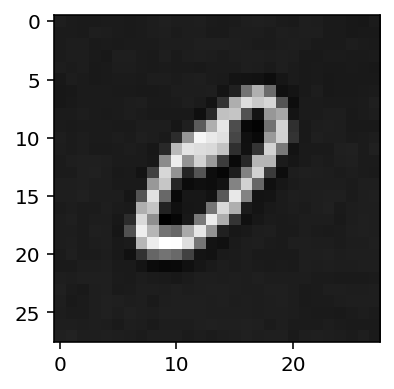

In [24]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [25]:
top_probs.squeeze().numpy()

array([9.7916174e-01, 2.0830579e-02, 3.9667693e-06, 2.0161360e-06,
       1.1848455e-06, 5.0145974e-07, 4.8041645e-08, 8.9108791e-09,
       2.4833742e-09, 7.4122858e-10], dtype=float32)

In [26]:
top_classes.squeeze().numpy()

array([0, 9, 1, 8, 6, 2, 7, 5, 3, 4])

In [27]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'0'

Predicted : 0
Ground Truth : 0


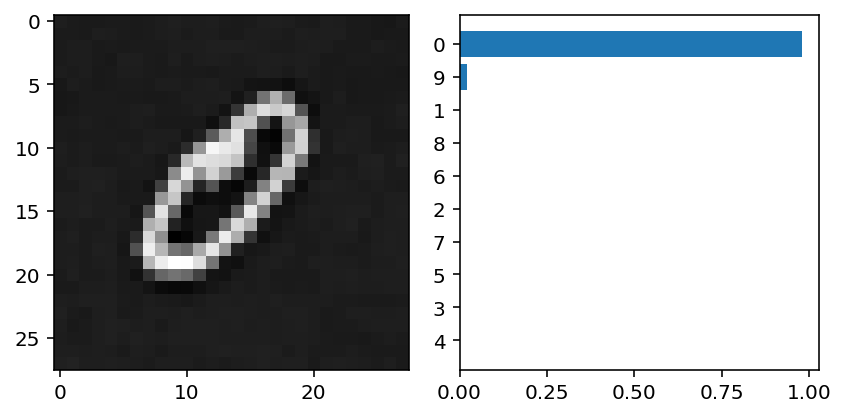

Accuracy: 0.979


In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 0]), 3))

In [29]:
image, label_correct = testloader.dataset[25]

In [30]:
label_correct = idx_to_class[label_correct]
label_correct

'1'

In [31]:
image.shape

torch.Size([1, 28, 28])

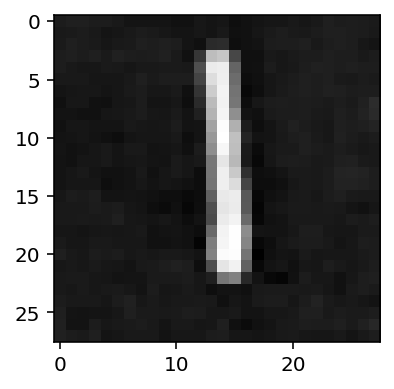

In [32]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [33]:
top_probs.squeeze().numpy()

array([9.9999094e-01, 7.8073563e-06, 9.5721748e-07, 1.5403806e-07,
       6.7360439e-08, 1.8580650e-08, 6.1325331e-09, 1.6135444e-09,
       7.2414497e-10, 4.8243371e-12], dtype=float32)

In [34]:
top_classes.squeeze().numpy()

array([1, 0, 6, 4, 9, 7, 8, 5, 2, 3])

In [35]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'1'

Predicted : 1
Ground Truth : 1


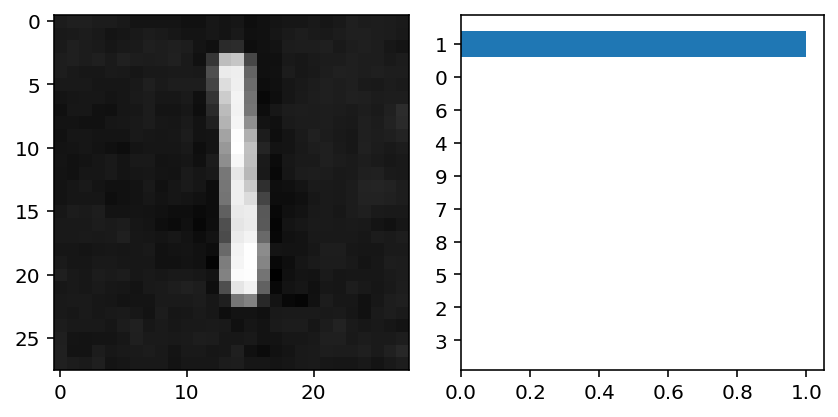

Accuracy: 1.0


In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 1]), 3))

In [215]:
image, label_correct = testloader.dataset[51]

In [216]:
label_correct = idx_to_class[label_correct]
label_correct

'2'

In [217]:
image.shape

torch.Size([1, 28, 28])

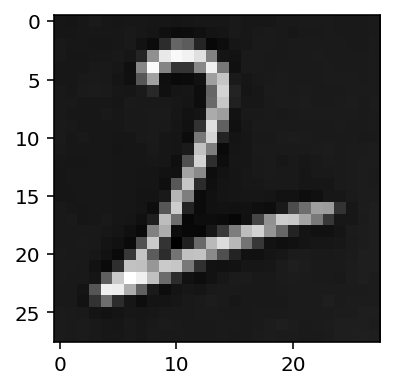

In [218]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [219]:
top_probs.squeeze().numpy()

array([6.6282219e-01, 2.0968020e-01, 1.2502889e-01, 2.3209071e-03,
       6.7329085e-05, 4.3716667e-05, 2.2090184e-05, 7.8418770e-06,
       6.6101452e-06, 2.9456342e-07], dtype=float32)

In [220]:
top_classes.squeeze().numpy()

array([2, 0, 1, 6, 9, 7, 8, 4, 3, 5])

In [221]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'2'

Predicted : 2
Ground Truth : 2


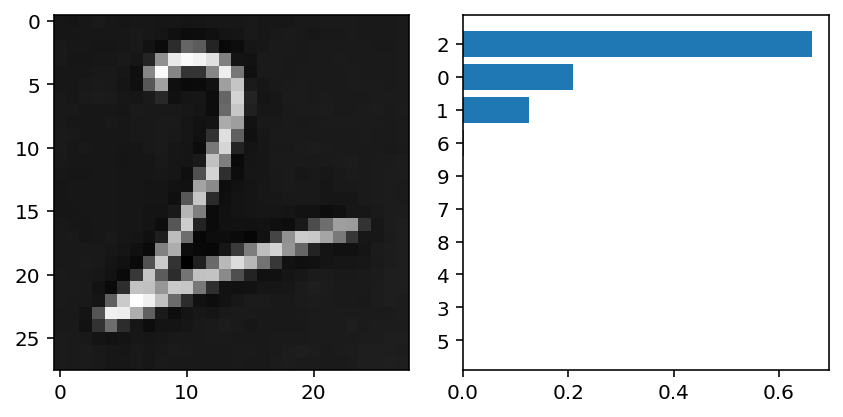

Accuracy: 0.663


In [222]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 2]), 3))

In [102]:
image, label_correct = testloader.dataset[81]

In [103]:
label_correct = idx_to_class[label_correct]
label_correct

'3'

In [104]:
image.shape

torch.Size([1, 28, 28])

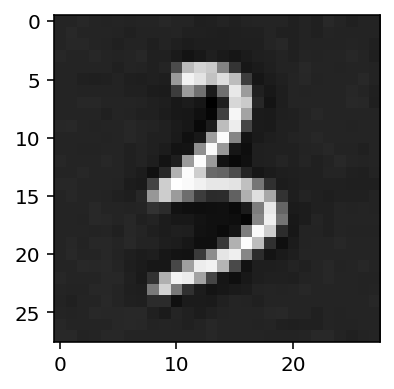

In [105]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [106]:
top_probs.squeeze().numpy()

array([8.73327196e-01, 3.85649279e-02, 3.65003832e-02, 3.09207961e-02,
       1.90282203e-02, 6.99474011e-04, 6.92416215e-04, 1.18028365e-04,
       1.12015892e-04, 3.65451087e-05], dtype=float32)

In [107]:
top_classes.squeeze().numpy()

array([3, 1, 6, 8, 0, 5, 9, 7, 2, 4])

In [108]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'3'

Predicted : 3
Ground Truth : 3


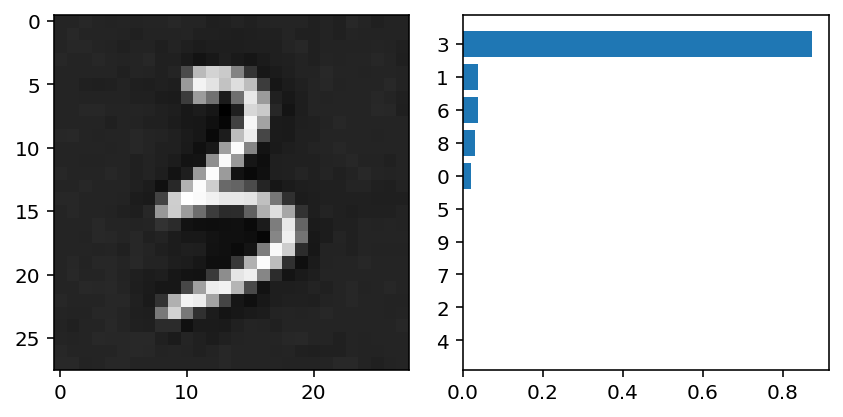

Accuracy: 0.873


In [109]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 3]), 3))

In [134]:
image, label_correct = testloader.dataset[103]

In [135]:
label_correct = idx_to_class[label_correct]
label_correct

'4'

In [136]:
image.shape

torch.Size([1, 28, 28])

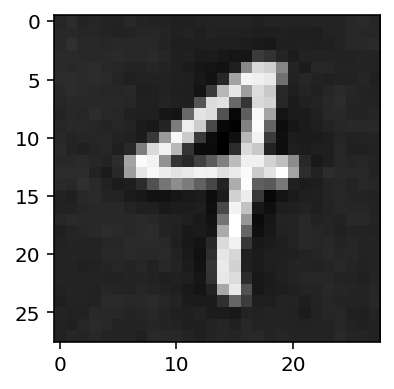

In [137]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [138]:
top_probs.squeeze().numpy()

array([7.3171496e-01, 1.5302962e-01, 1.0717388e-01, 5.0127394e-03,
       1.3758170e-03, 1.0344950e-03, 3.3904210e-04, 2.8121227e-04,
       3.7826361e-05, 2.8464257e-07], dtype=float32)

In [139]:
top_classes.squeeze().numpy()

array([4, 9, 1, 6, 8, 7, 0, 2, 5, 3])

In [140]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'4'

Predicted : 4
Ground Truth : 4


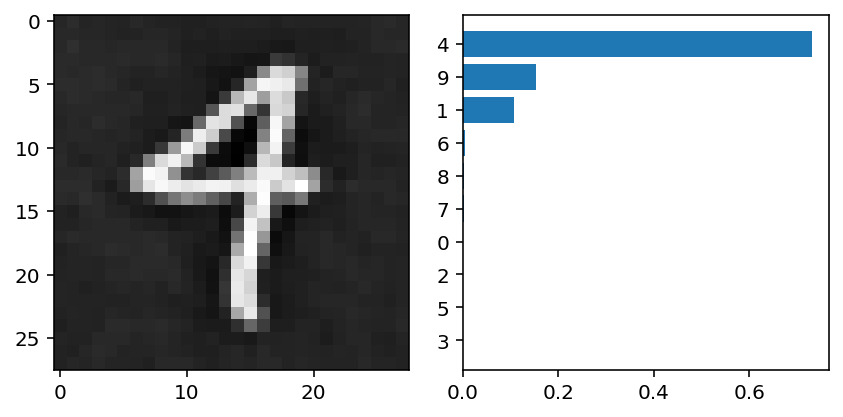

Accuracy: 0.732


In [142]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 4]), 3))

In [363]:
image, label_correct = testloader.dataset[126]

In [364]:
label_correct = idx_to_class[label_correct]
label_correct

'5'

In [365]:
image.shape

torch.Size([1, 28, 28])

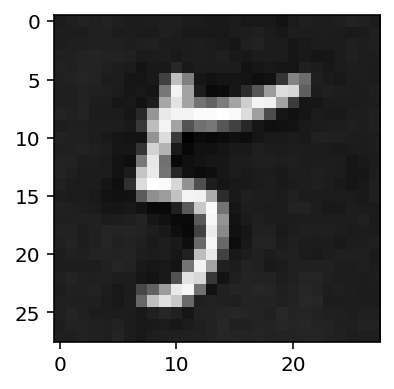

In [366]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [367]:
top_probs.squeeze().numpy()

array([8.5195196e-01, 1.0990657e-01, 1.8196648e-02, 1.2135111e-02,
       4.2589367e-03, 3.3999989e-03, 8.0175487e-05, 6.7869005e-05,
       2.6731329e-06, 9.0316803e-08], dtype=float32)

In [368]:
top_classes.squeeze().numpy()

array([5, 1, 0, 9, 8, 6, 7, 4, 2, 3])

In [369]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'5'

Predicted : 5
Ground Truth : 5


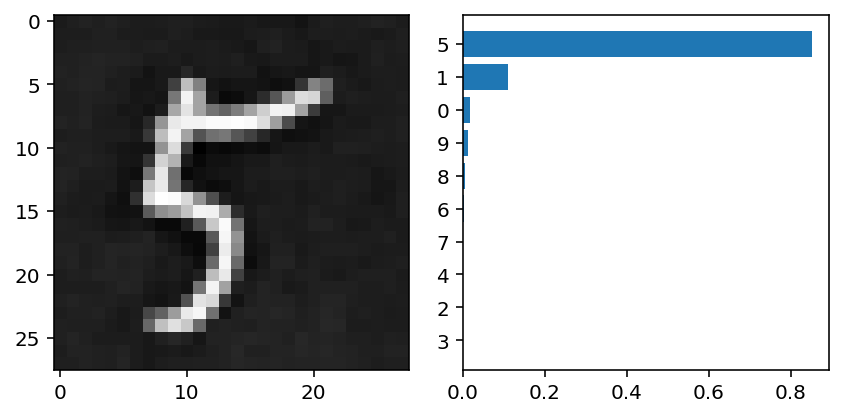

Accuracy: 0.852


In [370]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 5]), 3))

In [371]:
image, label_correct = testloader.dataset[138]

In [372]:
label_correct = idx_to_class[label_correct]
label_correct

'6'

In [373]:
image.shape

torch.Size([1, 28, 28])

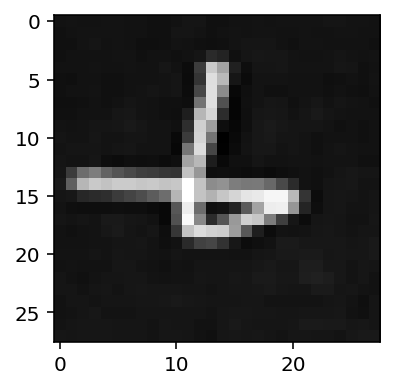

In [374]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [375]:
top_probs.squeeze().numpy()

array([9.86496747e-01, 9.15683154e-03, 2.27260985e-03, 1.99094415e-03,
       6.30652576e-05, 1.19777005e-05, 6.60554861e-06, 1.13642659e-06,
       1.02072789e-07, 1.86230462e-08], dtype=float32)

In [376]:
top_classes.squeeze().numpy()

array([6, 2, 1, 0, 4, 8, 5, 7, 9, 3])

In [377]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'6'

Predicted : 6
Ground Truth : 6


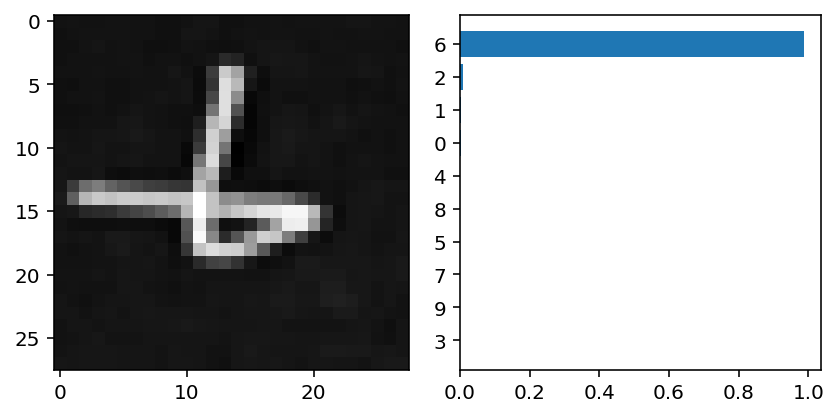

Accuracy: 0.986


In [379]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 6]), 3))

In [622]:
image, label_correct = testloader.dataset[189]

In [623]:
label_correct = idx_to_class[label_correct]
label_correct

'8'

In [624]:
image.shape

torch.Size([1, 28, 28])

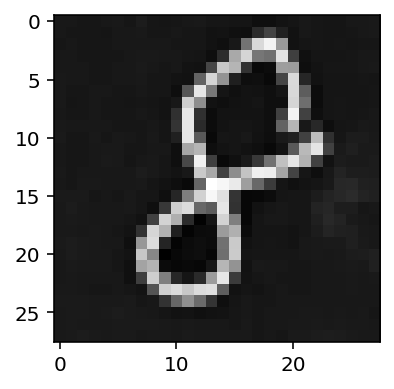

In [625]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [626]:
top_probs.squeeze().numpy()

array([9.9920517e-01, 3.9609108e-04, 3.1759668e-04, 7.3183204e-05,
       5.2131991e-06, 1.0591306e-06, 8.9141656e-07, 8.3314899e-07,
       6.0661276e-09, 6.9070832e-10], dtype=float32)

In [627]:
top_classes.squeeze().numpy()

array([8, 1, 0, 6, 9, 2, 5, 4, 7, 3])

In [628]:

label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'8'

Predicted : 8
Ground Truth : 8


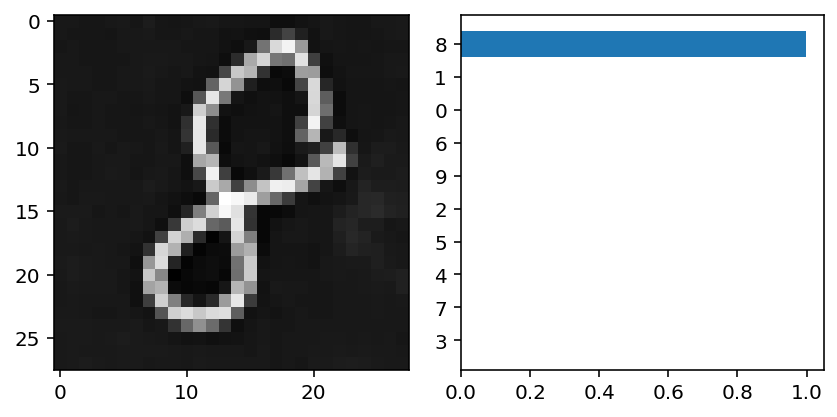

Accuracy: 0.999


In [629]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 8]), 3))

In [670]:
image, label_correct = testloader.dataset[214]

In [671]:
label_correct = idx_to_class[label_correct]
label_correct

'9'

In [672]:
image.shape

torch.Size([1, 28, 28])

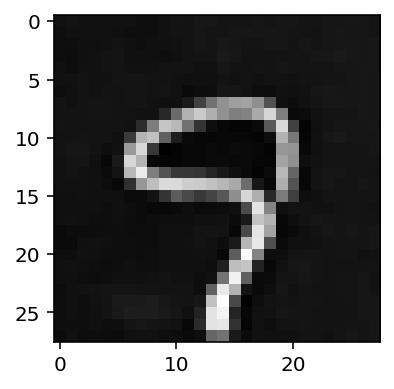

In [673]:
with torch.no_grad():
  image_batch = image.unsqueeze(0)
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3))
  ax = np.ravel(ax)
  ax[0].imshow(image_batch.squeeze(), cmap="gray")
  plt.show()
  
  logits = model.forward(image_batch)
  probabilities = logits.softmax(dim=1)
  top_probs, top_classes = probabilities.topk(k=10, dim=1)  

In [674]:
top_probs.squeeze().numpy()

array([9.60535586e-01, 2.15759799e-02, 1.71571281e-02, 4.05825587e-04,
       1.48162944e-04, 1.07186854e-04, 4.97607361e-05, 1.93920550e-05,
       9.35544222e-07, 2.00092742e-08], dtype=float32)

In [675]:
top_classes.squeeze().numpy()

array([9, 0, 1, 7, 5, 4, 8, 6, 2, 3])

In [676]:
label_predicted = idx_to_class[int(top_classes.squeeze()[0])]
label_predicted

'9'

Predicted : 9
Ground Truth : 9


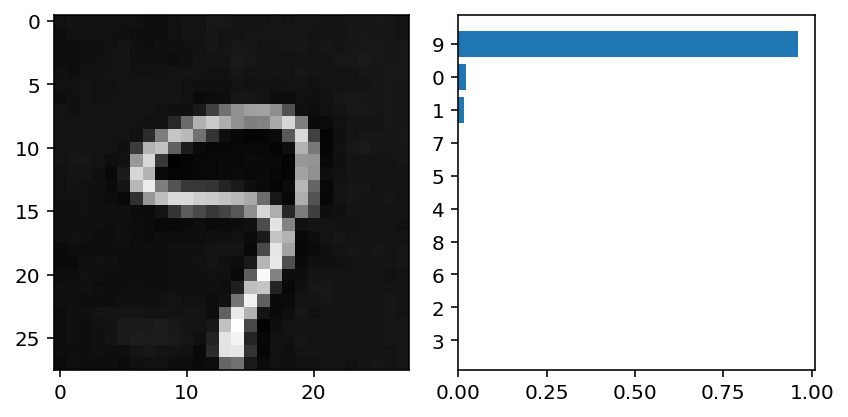

Accuracy: 0.961


In [677]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,3))
ax = np.ravel(ax)
print(f"Predicted : {label_predicted}") 
print(f"Ground Truth : {label_correct}")
ax[0].imshow(image.squeeze(), cmap="gray")
labels = [idx_to_class[x] for x in top_classes.squeeze().numpy()]
probs = top_probs.squeeze().numpy()
ax[1].barh(np.arange(len(labels)), probs)
ax[1].set_yticks(np.arange(len(labels)))
ax[1].set_yticklabels(labels)
ax[1].invert_yaxis()
plt.tight_layout()
plt.show()
print("Accuracy:",round(float(top_probs.squeeze().numpy()[top_classes.squeeze().numpy() == 9]), 3))